In [45]:
import glob
pngs = glob.glob("e:/github/lin*/COVID*/data/train/*.png")

import cv2
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

import imageio
import numpy as np
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
sz = 128
imgs = []
for png in pngs[:100]:
    if len(imgs) % 100 == 0:
        print('{0} of {1}'.format(len(imgs), len(pngs)), end = '\r')
    img = imageio.imread(png)
    if len(img.shape) > 2:
        img = rgb2gray(img)
        img = img_as_ubyte(img)
    img = clahe.apply(img)
    img = resize(img, (sz,sz))
    width = np.max(img) - np.min(img)
    img = img - np.min(img)
    img = img/width
    img = img.reshape((sz,sz,1))
    imgs = imgs + [img]

In [2]:
def sampling(args):
    """
    Reparameterization trick by sampling fr an isotropic unit Gaussian.
    instead of sampling from Q(z|X), sample eps = N(0,I) 
        then z = z_mean + sqrt(var)*eps    
    # Arguments
        args (tensor tuple): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """    
    z_mean, z_log_var = args
    
    from keras import backend as K
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
from keras.layers import Dense, Input, SpatialDropout2D
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import LocallyConnected2D, ZeroPadding2D
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import ActivityRegularization
from keras import backend as K

latent_dim = 8
plot_model = False
cit_decimate = False

# create encoder side
retina = Input(shape=(sz,sz,1), name='retina_{}'.format(sz))

v1_conv2d = Conv2D(16, (5,5), name='v1_conv2d', activation='relu', padding='same')(retina)
v1_maxpool = MaxPooling2D((2,2), name='v1_maxpool', padding='same')(v1_conv2d)
v1_dropout = SpatialDropout2D(0.1, name='v1_dropout')(v1_maxpool)

v2_conv2d = Conv2D(16, (3,3), name='v2_conv2d', activation='relu', padding='same')(v1_dropout)
v2_maxpool = MaxPooling2D((2,2), name='v2_maxpool', padding='same')(v2_conv2d)

v4_conv2d = Conv2D(32, (3,3), name='v4_conv2d', activation='relu', padding='same')(v2_maxpool)
v4_maxpool = MaxPooling2D((2,2), name='v4_maxpool', padding='same')(v4_conv2d)

pit_conv2d = Conv2D(32, (3,3), name='pit_conv2d', activation='relu', padding='same')(v4_maxpool)
pit_maxpool = MaxPooling2D((2,2), name='pit_maxpool', padding='same')(pit_conv2d)

cit_conv2d = Conv2D(64, (3,3), name='cit_conv2d', activation='relu', padding='same')(pit_maxpool)
if cit_decimate:
    cit_maxpool = MaxPooling2D((2,2), name='cit_maxpool', padding='same')(cit_conv2d)
    cit_out = cit_maxpool
else:
    cit_out = cit_conv2d
    
ait_local = LocallyConnected2D(4, (3,3), name='ait_local')(cit_out)
# ait_padding = ZeroPadding2D(padding=(1,1), name='ait_padding')(ait_local)
# x = MaxPooling2D((2,2), padding='same', name='ait_maxpool')(ait_padding)

ait_regular = ActivityRegularization(l1=0.0e-4, l2=0.0e-4, name='ait_regular')(ait_local)

# shape info needed to build decoder model
shape = K.int_shape(ait_regular)
# print(shape)

# generate latent vector Q(z|X)
pulvinar_flatten = Flatten(name='pulvinar_flatten')(ait_regular)
pulvinar_dense = Dense(latent_dim, activation='relu', name='pulvinar_dense')(pulvinar_flatten)
z_mean = Dense(latent_dim, name='z_mean')(pulvinar_dense)
z_log_var = Dense(latent_dim, name='z_log_var')(pulvinar_dense)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

from keras.models import Model
encoder = Model(retina, [z_mean, z_log_var, z], name='v1_to_pulvinar_encoder')
encoder.summary()
encoder.load_weights('data\zebrastack_v0_covidnet_encoder_model')

Using TensorFlow backend.


Model: "v1_to_pulvinar_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
retina_128 (InputLayer)         (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
v1_conv2d (Conv2D)              (None, 128, 128, 16) 416         retina_128[0][0]                 
__________________________________________________________________________________________________
v1_maxpool (MaxPooling2D)       (None, 64, 64, 16)   0           v1_conv2d[0][0]                  
__________________________________________________________________________________________________
v1_dropout (SpatialDropout2D)   (None, 64, 64, 16)   0           v1_maxpool[0][0]                 
_____________________________________________________________________________

In [46]:
encoder.predict([imgs])[2]

array([[-3.22907567e+00,  1.04921031e+00, -1.75775719e+00,
        -1.80450773e+00, -2.48706079e+00, -2.26080418e+00,
         1.15988410e+00,  1.09474945e+00],
       [ 1.08975321e-01, -1.78688037e+00, -1.69165981e+00,
        -4.62709725e-01,  7.80988485e-02, -1.10481501e-01,
         8.97831023e-01, -4.75330114e-01],
       [-3.41858566e-01,  7.64470279e-01, -1.56330788e+00,
        -6.09164089e-02, -2.34012812e-01, -1.79326922e-01,
         3.24875824e-02, -5.97251296e-01],
       [-1.29105055e+00,  6.14754975e-01, -5.32783031e-01,
         3.17649305e-01, -1.61252141e+00, -8.36787164e-01,
        -9.67051208e-01, -1.21970549e-02],
       [-4.34781849e-01,  3.20780247e-01, -2.00335845e-01,
        -5.11783779e-01, -6.17040455e-01,  3.51923227e-01,
        -1.41491365e+00,  1.76516473e-02],
       [-8.06259036e-01,  1.24797368e+00, -1.46886992e+00,
        -1.27009594e+00,  2.25893319e-01,  1.74769297e-01,
        -7.90760443e-02, -8.23078275e-01],
       [-7.68509984e-01,  7.478769

In [47]:
import matplotlib.pyplot as plt
def show_grayscale(rows, columns, at, pixel_array, sz):
    import scipy
    ax = plt.subplot(rows, columns, at)
    interp_array = scipy.ndimage.zoom(pixel_array.reshape(sz,sz), 4.0, order=5)
    plt.imshow(interp_array.reshape(sz*4, sz*4), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def show_original_decoded(original, decoded, sz):
    n = 10  # how many figures we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        show_grayscale(2, n, i+1, original[i], sz)
        show_grayscale(2, n, i+1+n, decoded[i], sz)
    plt.show(block=True)

 final_simplex: (array([[ 6.16762492e-06, -2.42271857e-04,  1.80184604e-04,
        -2.29554748e-04,  1.94350325e-04,  7.15185640e-05],
       [ 6.16762492e-06, -2.42271857e-04,  1.80184604e-04,
        -2.29554748e-04,  1.94350325e-04,  7.15185640e-05],
       [ 6.16762492e-06, -2.42271857e-04,  1.80184604e-04,
        -2.29554748e-04,  1.94350325e-04,  7.15185640e-05],
       [ 6.16762492e-06, -2.42271857e-04,  1.80184604e-04,
        -2.29554748e-04,  1.94350325e-04,  7.15185640e-05],
       [ 6.16762492e-06, -2.42271857e-04,  1.80184604e-04,
        -2.29554748e-04,  1.94350325e-04,  7.15185640e-05],
       [ 6.16762492e-06, -2.42271857e-04,  1.80184604e-04,
        -2.29554748e-04,  1.94350325e-04,  7.15185640e-05],
       [ 6.16762492e-06, -2.42271857e-04,  1.80184604e-04,
        -2.29554748e-04,  1.94350325e-04,  7.15185640e-05]]), array([1.51584888, 1.65330303, 1.65741253, 1.67222858, 1.68425036,
       1.6850636 , 1.69057846]))
           fun: 1.5158488760019802
       messag

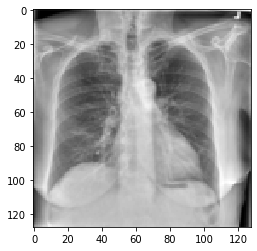

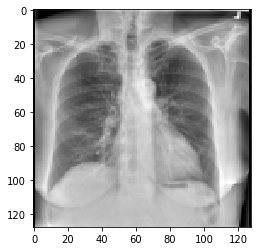

In [73]:
use_shear = False
def xform_params(x):
    import math
    params = {'theta':x[0], 'tx':x[1], 'ty':x[2], 'zx':math.exp(x[3]/30), 'zy':math.exp(x[4]/30)}
    if use_shear:
        params['shear'] = x[5]
    return params

def xform_image(params, img):
    from tensorflow.keras.preprocessing.image import apply_affine_transform as transform
    return transform(img, **params, fill_mode='constant', cval=0.0)

weight_prior = 1.0/100.0
def xform_prior_logsq(x):
    theta_prior = x[0] * x[0]
    shear_prior = x[5] * x[5]
    scale_prior = x[3] * x[3] + x[4] * x[4]
    return theta_prior + shear_prior + scale_prior

def xformed_latent(x, img):
    params = xform_params(x)
    xformed = xform_image(params, img)
    latent_vector = encoder.predict([[xformed]])[2]
    prior = xform_prior_logsq(x)
    return np.linalg.norm(latent_vector) + weight_prior * prior
    
dump = True
def shift(img):
    from scipy.optimize import minimize
    res = minimize(xformed_latent, np.zeros((6,)), 
                   # method='powell', 
                   method='nelder-mead', 
                   args=img,
                   options={'xtol': 1e-12, 
                            'ftol': 1e-12,
                            'maxiter': 10000,
                            'disp': dump})
    params = xform_params(res.x)
    if dump:
        print(res)
    import pprint
    pprint.pprint(params)
    return xform_image(params, img)

img = imgs[34]
xformed = shift(img)
dump = False
plt.figure(); plt.imshow(img.reshape(sz, sz), cmap='gray')
plt.figure(); plt.imshow(xformed.reshape(sz, sz), cmap='gray')

{'theta': -0.9122794664092079,
 'tx': -0.36690895309702776,
 'ty': 2.341017791834756,
 'zx': 1.0039418609788466,
 'zy': 1.0469291067160784}
{'theta': -0.18101180407896011,
 'tx': -0.8595911309885109,
 'ty': -3.305613936733345,
 'zx': 1.0045304536867552,
 'zy': 0.9905557635852508}
{'theta': 0.10820565744356528,
 'tx': -0.8540274847458315,
 'ty': -0.24258140419735913,
 'zx': 0.9988656886904909,
 'zy': 1.0241938148010776}
{'theta': -1.7082045444895482,
 'tx': -1.4949175608787189,
 'ty': 0.14217392975169973,
 'zx': 0.9956928147203904,
 'zy': 0.9961035710562988}
{'theta': 0.06130721826084605,
 'tx': 4.6286922417452825,
 'ty': -1.2736178479351912,
 'zx': 0.9173859682785546,
 'zy': 1.0548944983480768}
{'theta': 1.0953971500768973,
 'tx': -3.572933910594438,
 'ty': 2.3998956032565824,
 'zx': 1.0019468243546068,
 'zy': 1.0138707377760379}
{'theta': 2.3998250140583917,
 'tx': -0.28351831798177396,
 'ty': 9.013181916180127,
 'zx': 1.0048610202530288,
 'zy': 0.86942106273351}
{'theta': -0.45664310

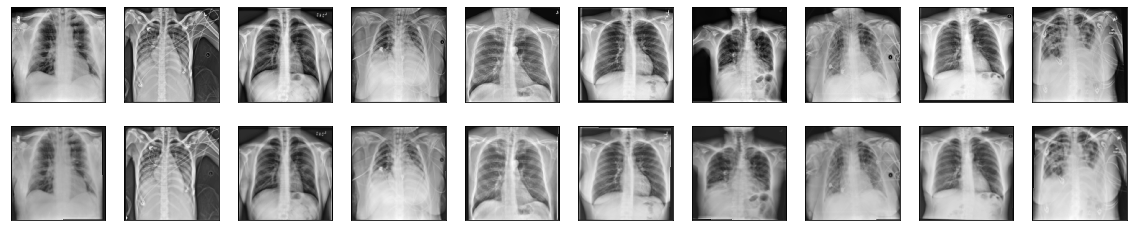

In [71]:
shifted = [shift(img) for img in imgs[10:20]]
show_original_decoded(imgs[10:20], shifted[:10], sz)